In [31]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import random
from random import sample as smpl
from tqdm import tqdm

In [88]:
class AutoEncoder:
    def __init__(self,training_data,hidden_neurons,batch_size,learning_rate,parameters):
        self.train_data = training_data.T #taking transpose of training data
        #initializing the input and out arrays for weights
        a = 6/(256+hidden_neurons+1) #this value is given in the assignment for weight initializion
        self.weights_input_hidden = np.random.uniform(-np.sqrt(a),np.sqrt(a),size=(257,hidden_neurons))
        self.weights_hidden_output = np.random.uniform(-np.sqrt(a),np.sqrt(a),size=(hidden_neurons+1,256))
        self.hidden_layer = None
        self.output_layer = None
        self.batch_size = batch_size
        self.lr = learning_rate
        self.parameters = parameters
        self.hidden_neurons = hidden_neurons

#sigmoid activation function for our nn
    def sigmoid(self,t):
        return 1/(1+np.exp(-t))
#implementation of feedforward
    def feedforward(self, sample):
        y = np.dot(self.weights_input_hidden.T,np.append(np.ones((1,len(sample[0]))), sample,axis=0))
        self.hidden_layer = self.sigmoid(y)
        o = self.weights_hidden_output.T@np.append(np.ones((1,len(sample[0]))), self.hidden_layer,axis=0)
        self.output_layer = o
#updating weights based on aeCost function
    def update_weigths(self):
        total_cost = 0
        for i in range(len(self.train_data[0])//self.batch_size):
            batch_cost,hidden_batch_gradient,out_batch_gradient = self.aeCost(self.train_data[:,i*self.batch_size:(i+1)*self.batch_size])
            self.weights_hidden_output = self.weights_hidden_output - self.lr*out_batch_gradient
            self.weights_input_hidden = self.weights_input_hidden - self.lr*hidden_batch_gradient
#aeCost function using mean squared cost, regularization and kl cost            
    def aeCost(self,batch):
        difference_network_outputs_sum = sum((self.output_layer-batch)**2)
        hidden_output_weights_squared = sum(self.weights_hidden_output**2)
        hidden_input_weights_squared = sum(self.weights_input_hidden**2)
        self.feedforward(batch)
        mean_squared_error_cost = sum(difference_network_outputs_sum)/(2*self.batch_size)
        regularization_cost = (sum(hidden_output_weights_squared)+sum(hidden_input_weights_squared))*self.parameters[0]/2
        rho_value_changed = np.sum(self.hidden_layer,axis=1)/len(self.hidden_layer[0])
        kl_cost = self.parameters[1]*sum(self.parameters[2]*np.log(self.parameters[2]/rho_value_changed)+(1-self.parameters[2])*np.log((1-self.parameters[2])/(1-rho_value_changed)))
        total_cost = mean_squared_error_cost+regularization_cost+kl_cost
        derivatie_weights_hidden_output = np.append(np.ones((1,len(batch[0]))), self.hidden_layer,axis=0)@(self.output_layer-batch).T/self.batch_size + self.parameters[0]*np.append(np.zeros((1,256)),self.weights_hidden_output[1:],axis=0)
        derivative_star_hat = self.weights_hidden_output[1:]@(self.output_layer-batch)/len(batch) + self.parameters[1]*(-self.parameters[2]/rho_value_changed + (1-self.parameters[2])/(1 - rho_value_changed)).reshape(self.hidden_neurons,1)
        derivative_hat = derivative_star_hat * self.hidden_layer*(1-self.hidden_layer)
        derivative_weights_input_hidden = np.append(np.ones((1,len(batch[0]))), batch,axis=0)@derivative_hat.T + self.parameters[0]*np.append(np.zeros((1,self.hidden_neurons)),self.weights_input_hidden[1:],axis=0)
        return total_cost,derivative_weights_input_hidden,derivatie_weights_hidden_output

# train function for training our network
    def train(self,epoch):
        self.mse = []
        pbar = tqdm(range(epoch), desc='description')
        for i in pbar:
            self.feedforward(self.train_data)
            self.mse.append(sum(sum((self.output_layer-self.train_data)**2))/(2*len(self.train_data[0])))
            pbar.set_description("Loss = {:.2f}".format(sum(sum((self.output_layer-self.train_data)**2))/(2*len(self.train_data[0]))))
            self.update_weigths()





In [75]:
data_path = "data1.h5"
with h5py.File(data_path, "r") as f:
    keys = f.keys()
    data = list(f[list(keys)[0]])

data_preprocessed = []
for image in data:
    one_layer = 0.2126*image[0]+0.7152*image[1]+0.0722*image[2]
    one_layer -= np.mean(one_layer)
    data_preprocessed.append(np.array(one_layer))

data_preprocessed = np.array(data_preprocessed)
data_preprocessed = np.clip(data_preprocessed, -3*np.std(data_preprocessed), 3*np.std(data_preprocessed))
data_preprocessed = np.interp(data_preprocessed, (np.min(data_preprocessed),np.max(data_preprocessed)),(0.1,0.9))


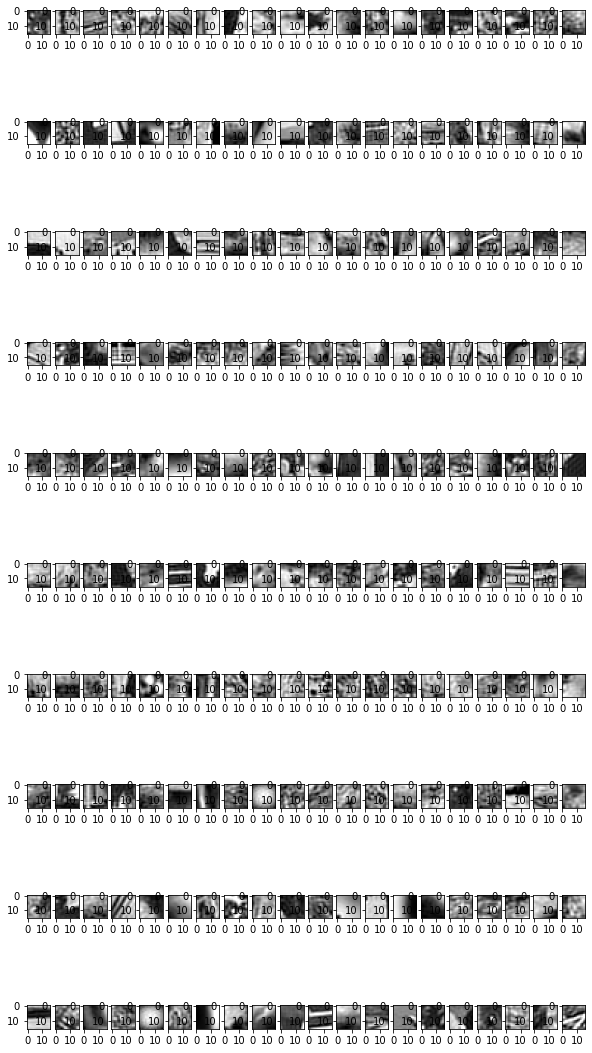

In [76]:
#%%
random_index_values = smpl(list(np.arange(0,len(data))), 200)
columns = 20
rows = 10
fig = plt.figure(figsize=(rows, columns))
for j in range (rows):
    for i in range(columns):
        fig.add_subplot(rows, columns, columns*j + i + 1)
        plt.imshow(data_preprocessed[random_index_values[20*j+i-1]].T,cmap="gray")
plt.savefig("0.png")
data_modified_flattened = data_preprocessed.reshape(len(data_preprocessed),256)
#%%




Loss = 0.66: 100%|███████████████████████████████████████████████████████████████████| 200/200 [02:34<00:00,  1.29it/s]


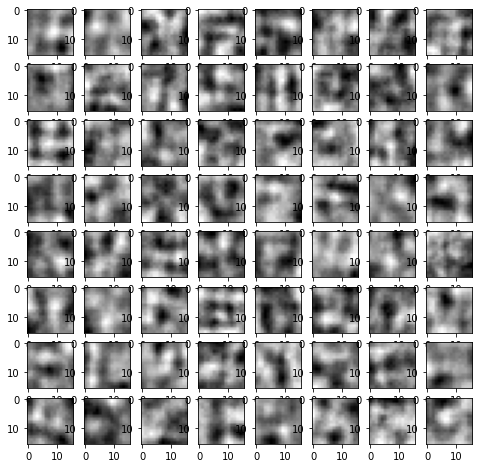

In [79]:
#%%
parameters = [5*10**(-4), 0.1, 0.1]
ae = AutoEncoder(data_modified_flattened, 64, 16, 0.05,parameters)
ae.train(200)
weights = ae.weights_input_hidden[1:]
columns = 8
rows = 8
fig=plt.figure(figsize=(8, 8))
for i in range(1, 65):
    fig.add_subplot(rows, columns, i)
    plt.imshow(weights[:,i-1].reshape(16,16),cmap="gray")
plt.savefig("1.png")


Loss = 0.84: 100%|███████████████████████████████████████████████████████████████████| 200/200 [02:33<00:00,  1.30it/s]


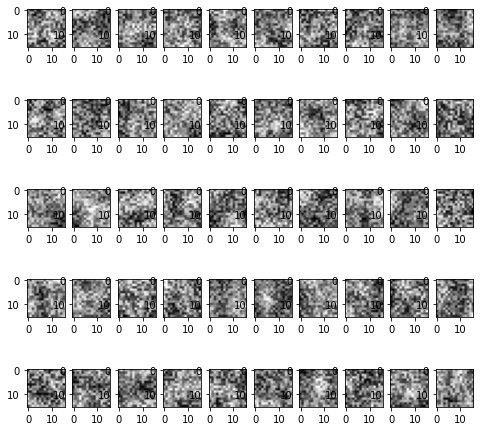

In [55]:
ae = AutoEncoder(data_modified_flattened, 50, 16, 0.01, parameters)
ae.train(200)
weights = ae.weights_input_hidden[1:]
columns = 10
rows = 5
fig=plt.figure(figsize=(8, 8))
for i in range(1, 51):
    fig.add_subplot(rows, columns, i)
    plt.imshow(weights[:,i-1].reshape(16,16),cmap="gray")
plt.savefig("3.png")


Loss = 0.92: 100%|███████████████████████████████████████████████████████████████████| 200/200 [01:58<00:00,  1.69it/s]


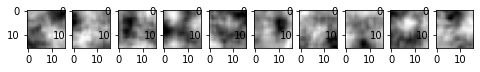

In [56]:
ae = AutoEncoder(data_modified_flattened, 10, 16, 0.1, parameters)
ae.train(200)
weights = ae.weights_input_hidden[1:]
columns = 10
rows = 1
fig=plt.figure(figsize=(8, 8))
for i in range(1, 11):
    fig.add_subplot(rows, columns, i)
    plt.imshow(weights[:,i-1].reshape(16,16),cmap="gray")
plt.savefig("4.png")

Loss = 0.89: 100%|███████████████████████████████████████████████████████████████████| 200/200 [02:15<00:00,  1.48it/s]


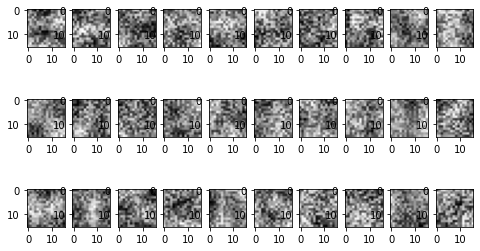

In [81]:
ae = AutoEncoder(data_modified_flattened, 30, 16, 0.01, parameters)
ae.train(200)
weights = ae.weights_input_hidden[1:]
columns = 10
rows = 3
fig=plt.figure(figsize=(8, 8))
for i in range(1, 31):
    fig.add_subplot(rows, columns, i)
    plt.imshow(weights[:,i-1].reshape(16,16),cmap="gray")
plt.savefig("2.png")